In [35]:
%matplotlib inline

from glob import glob
from pprint import pprint
from tabulate import tabulate
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


"Ready"

'Ready'

In [9]:
BENCHMARK_DESCRIPTION = "Benchmarks run on 25-dimensional Glove word vectors\n(http://nlp.stanford.edu/data/glove.twitter.27B.zip)"

In [2]:
def iter_metrics(globspec="metrics/metrics_*.json"):
    for p in glob(globspec):
        with open(p) as fp:
            yield json.load(fp)

In [3]:
"Found %d metrics files" % sum(1 for x in iter_metrics())

'Found 192 metrics files'

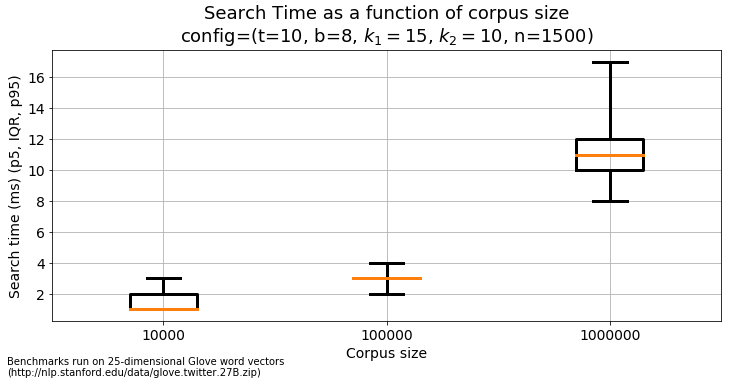

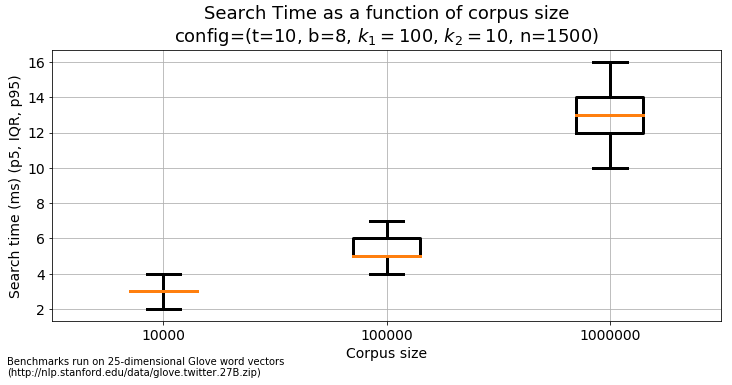

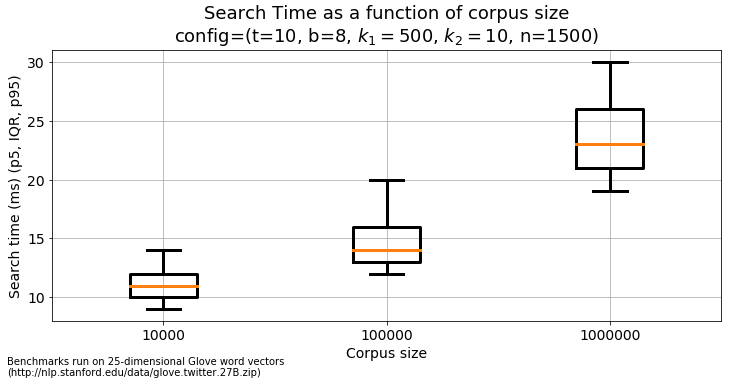

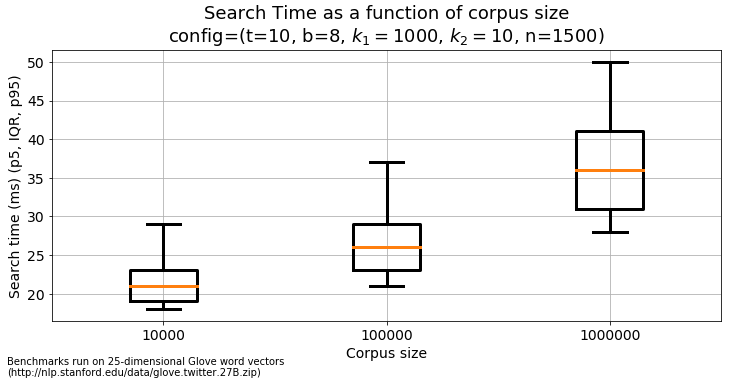

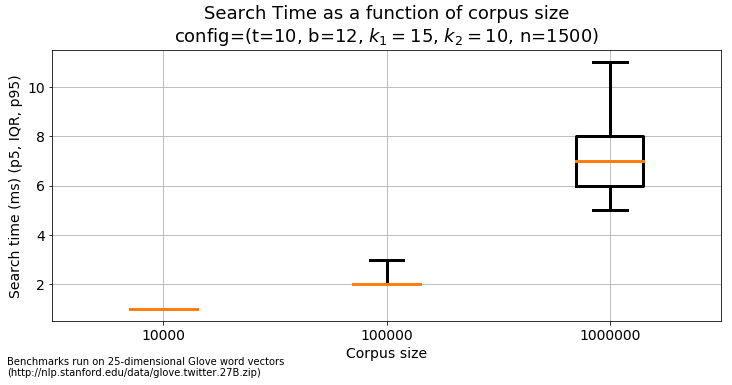

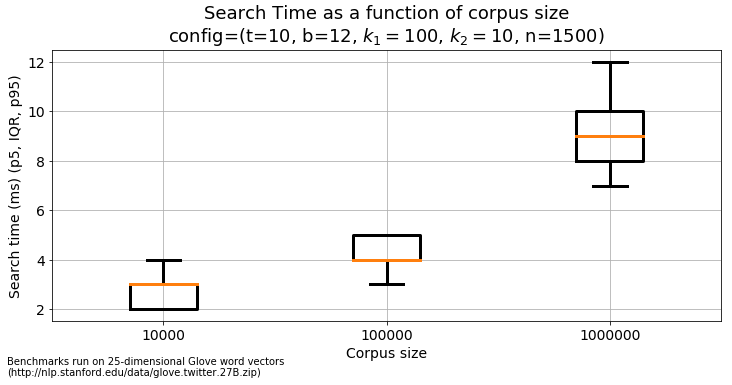

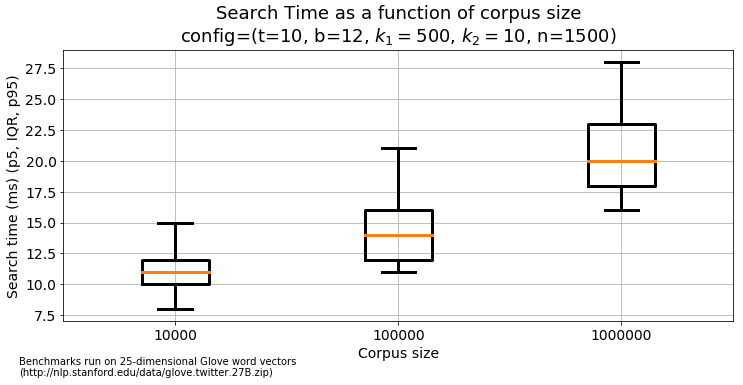

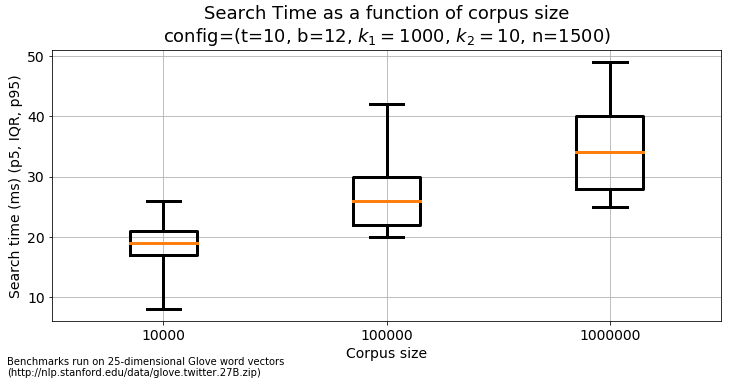

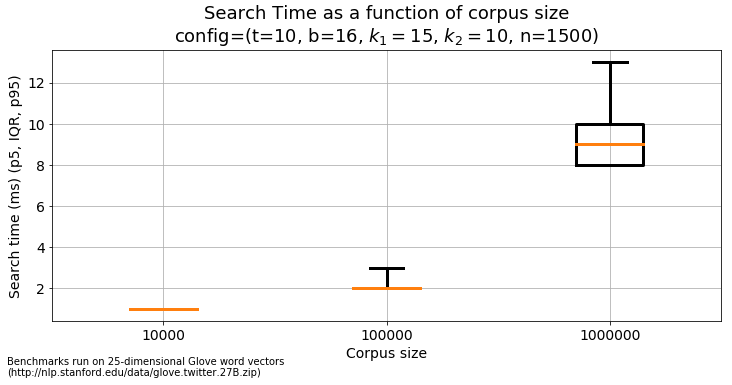

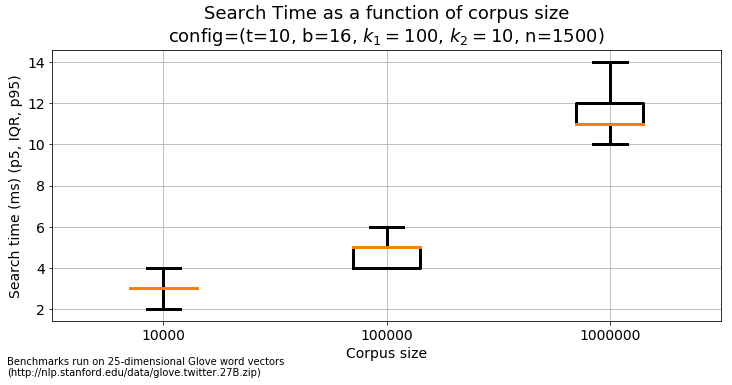

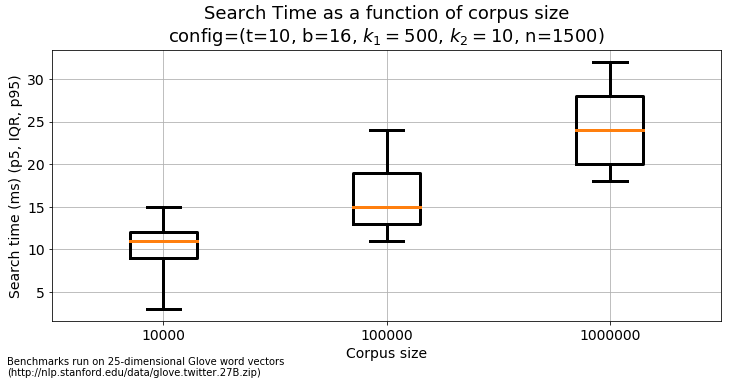

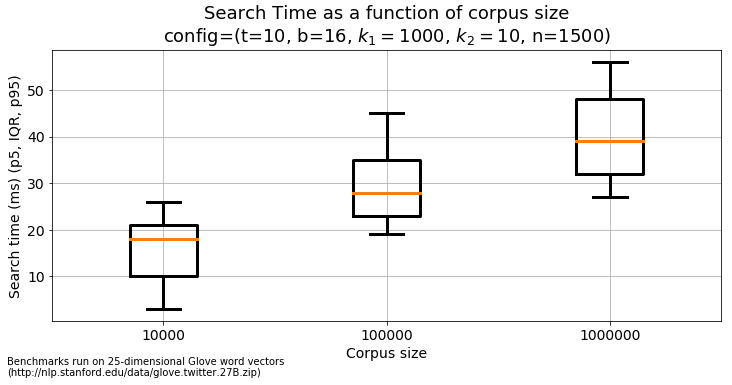

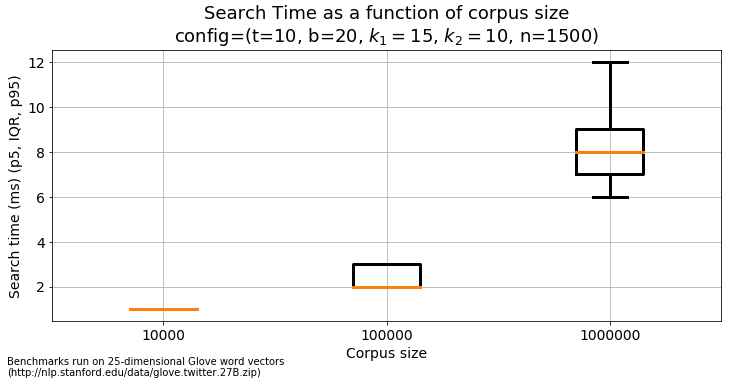

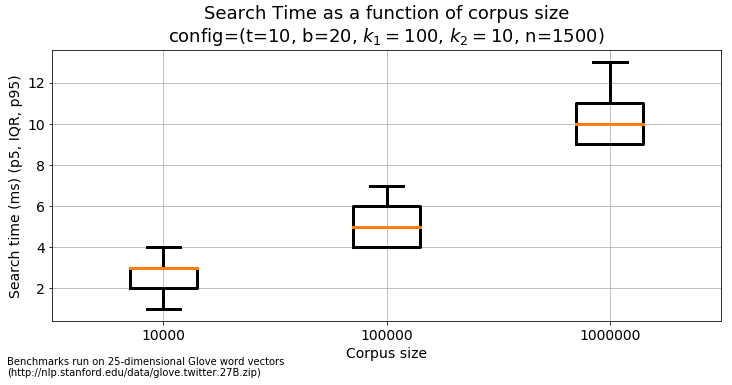

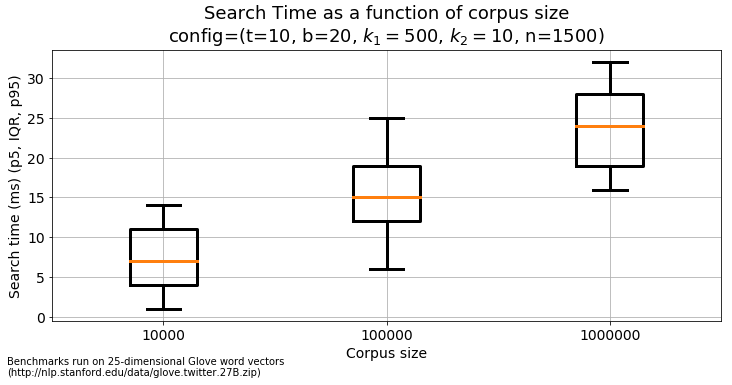

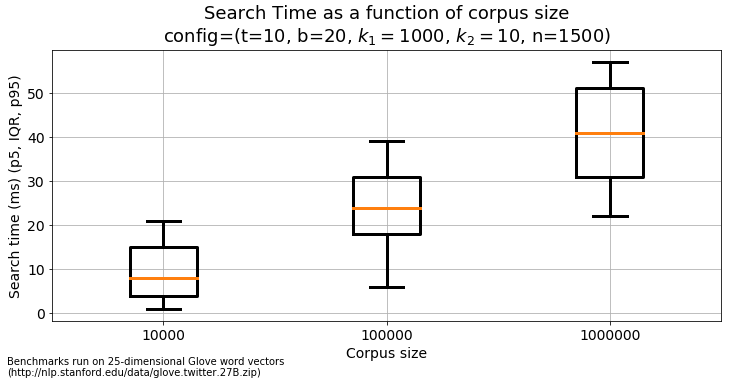

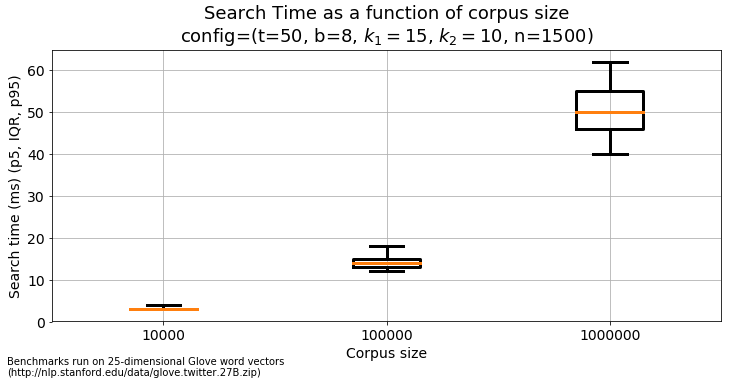

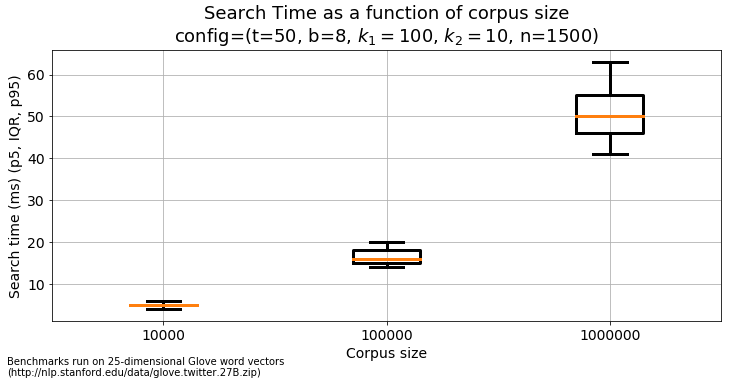

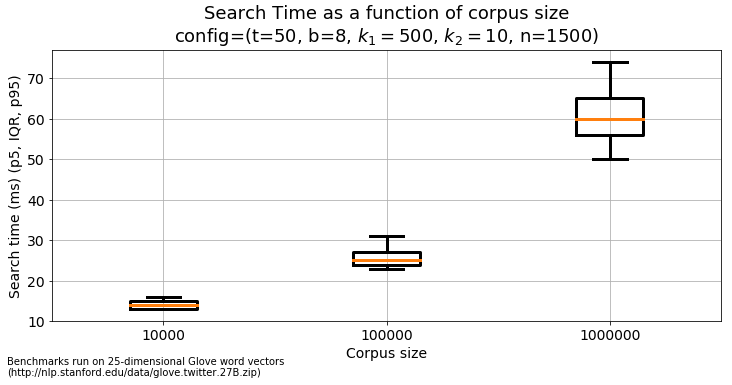

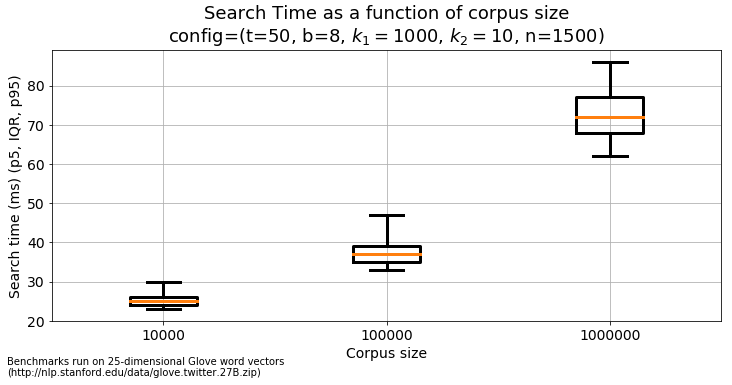

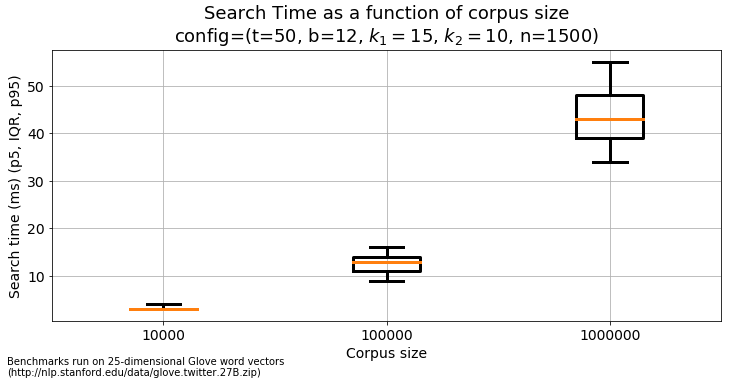

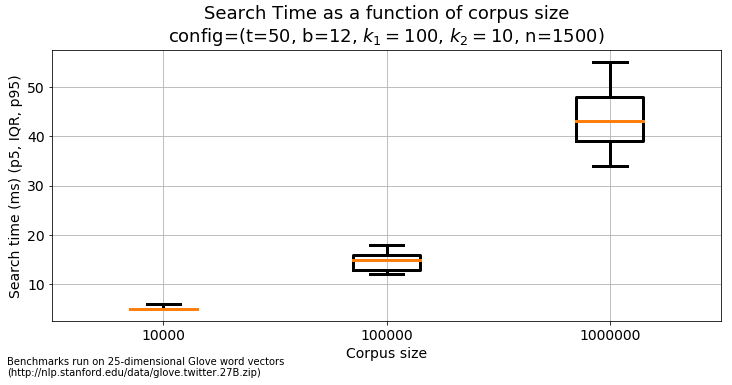

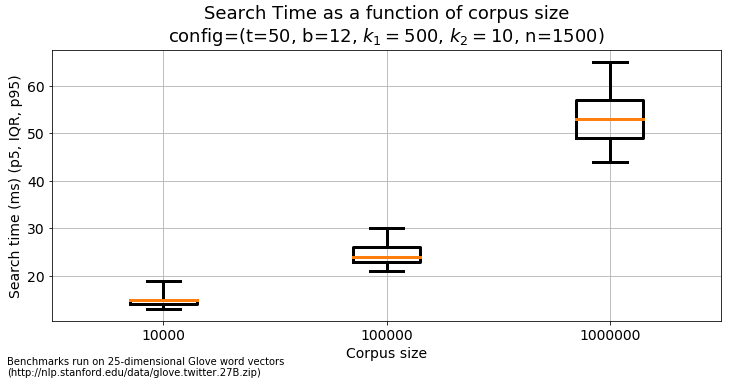

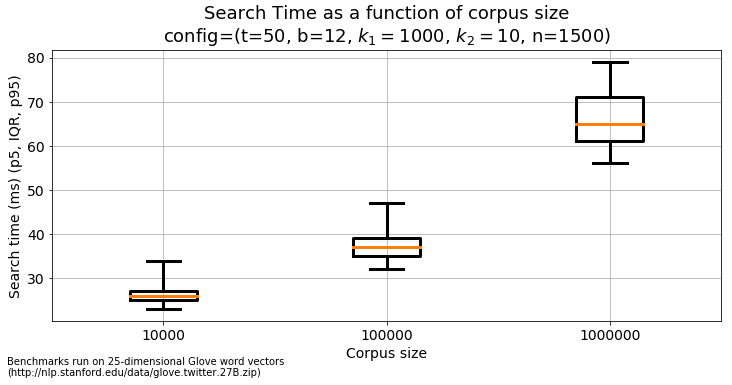

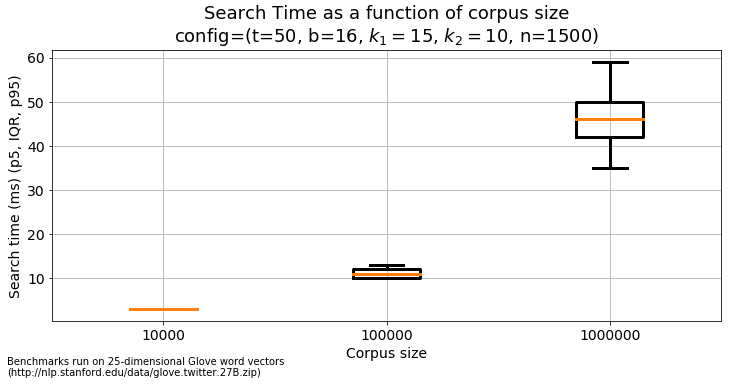

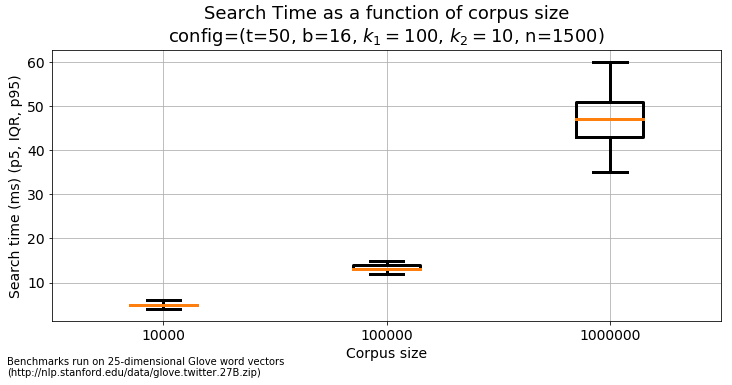

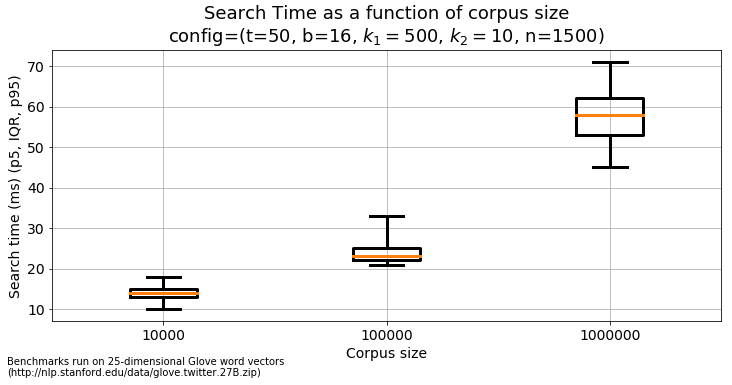

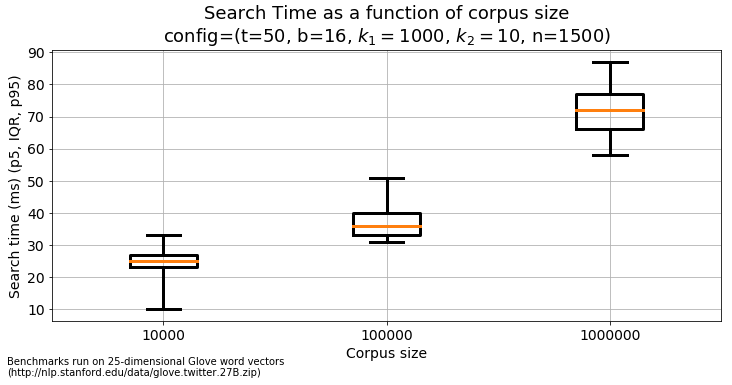

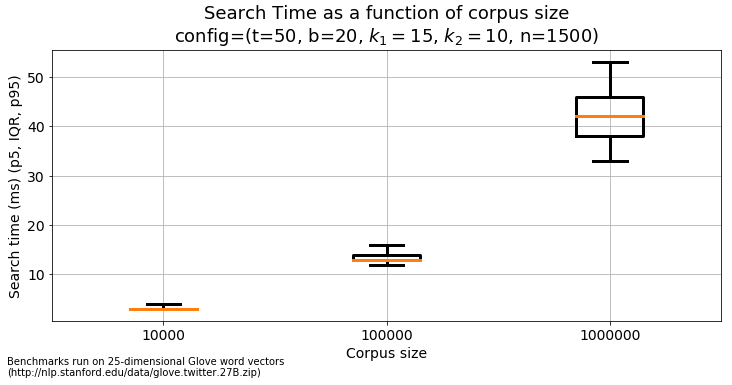

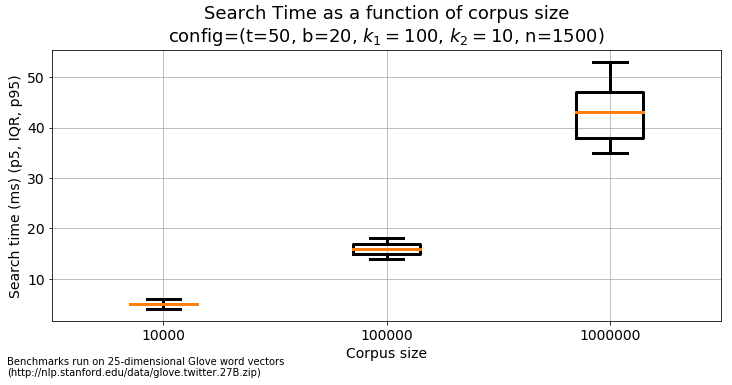

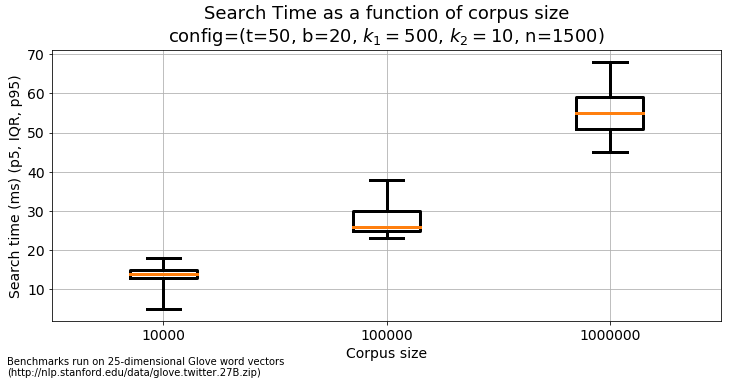

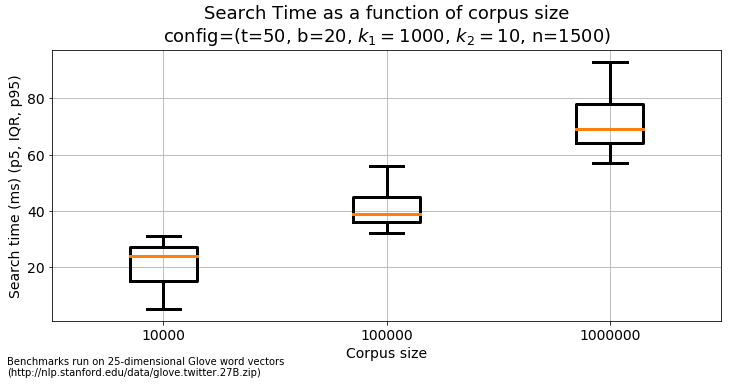

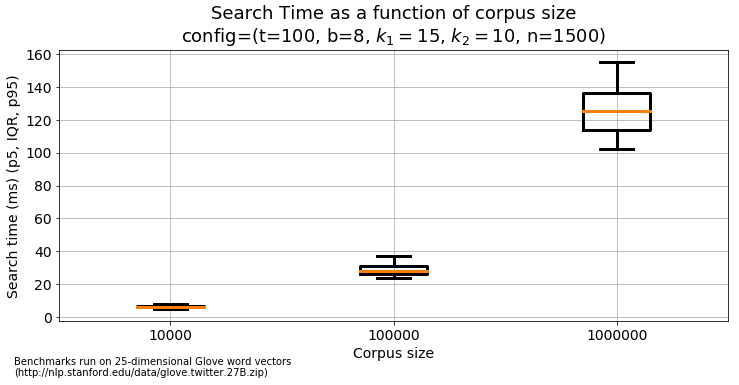

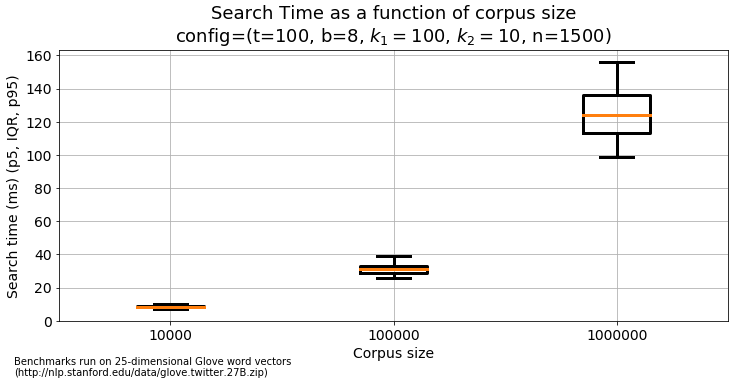

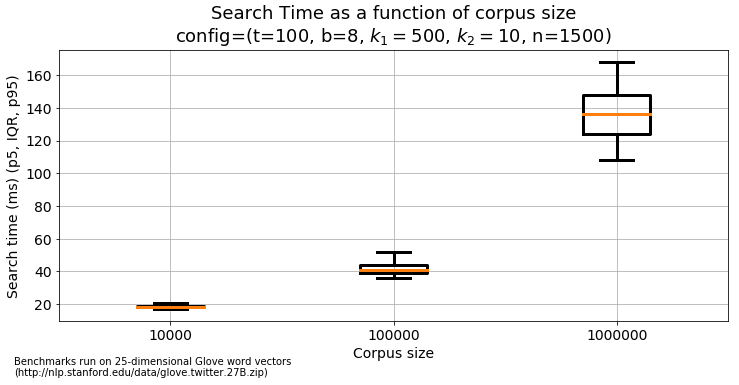

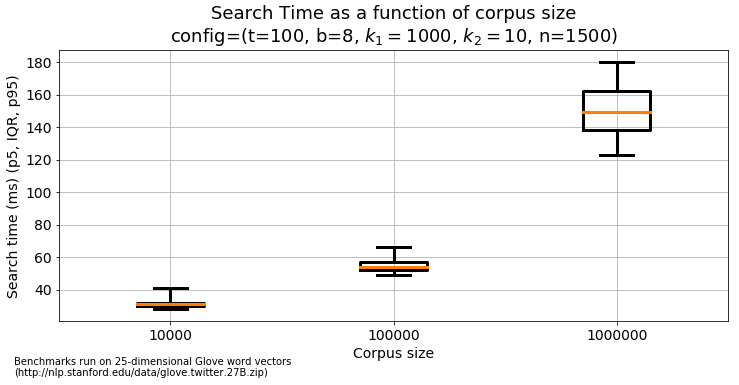

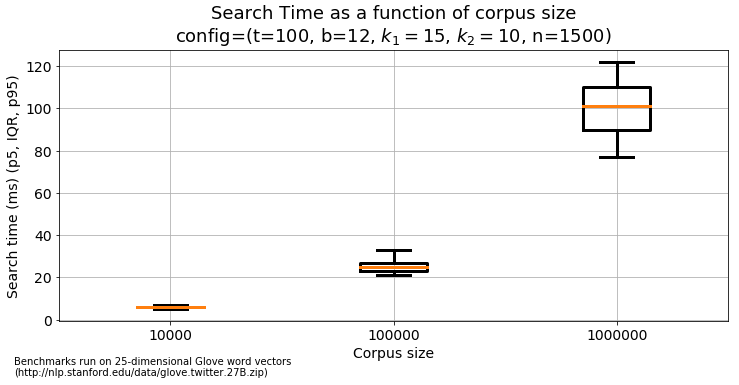

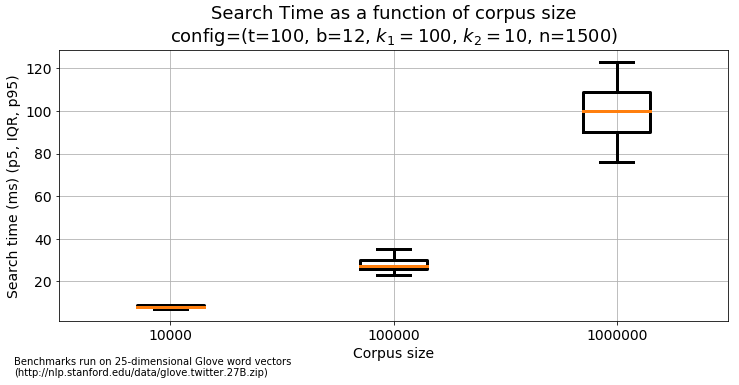

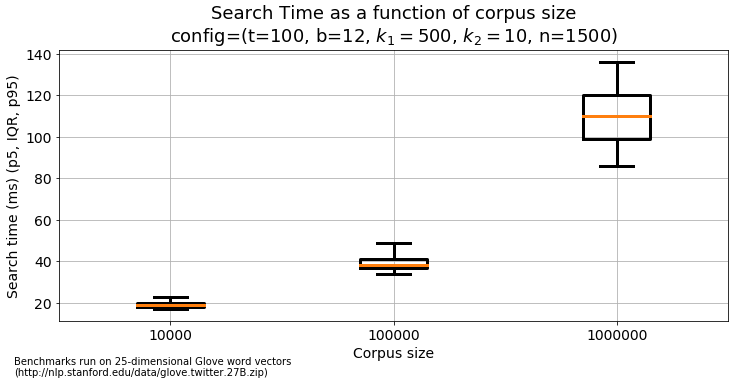

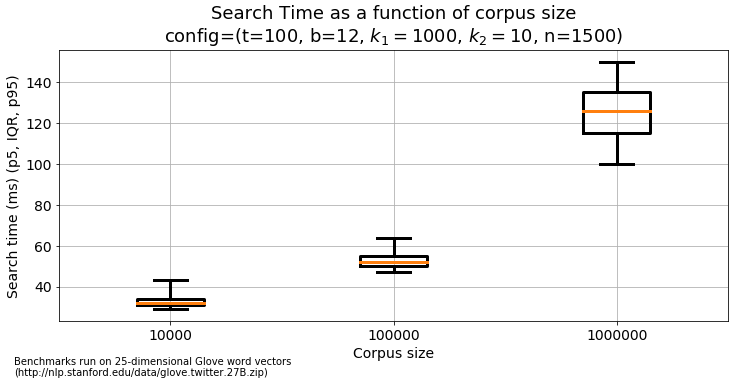

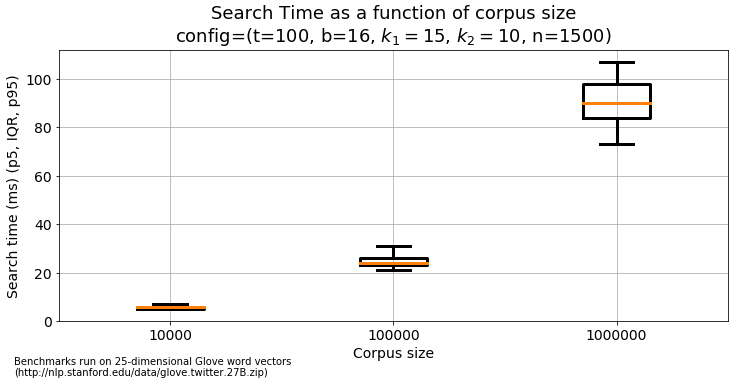

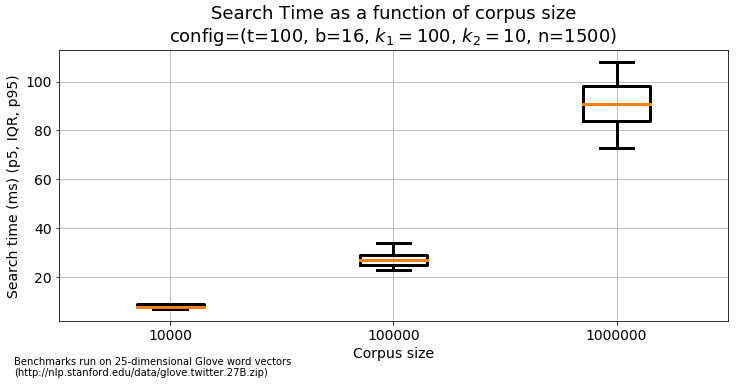

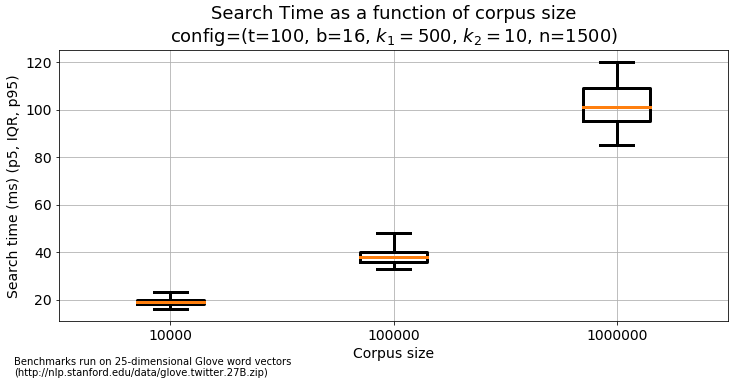

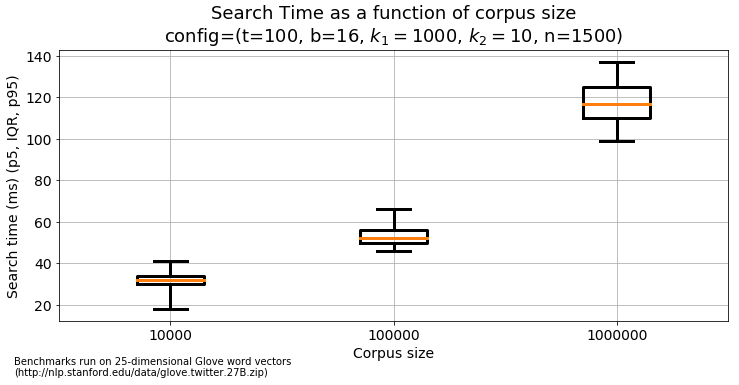

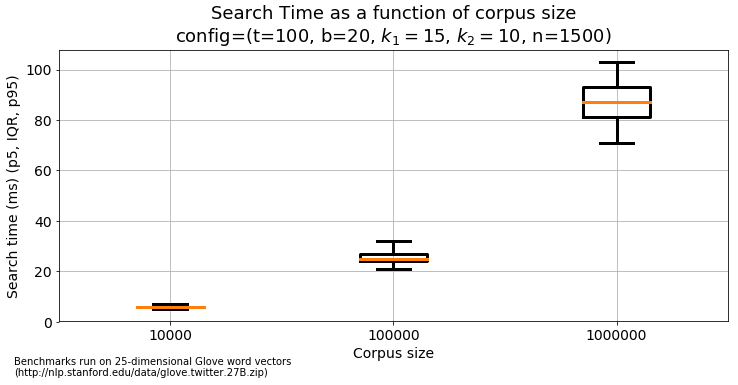

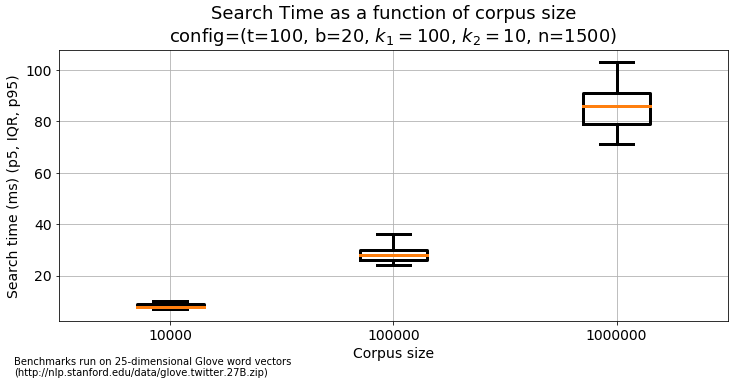

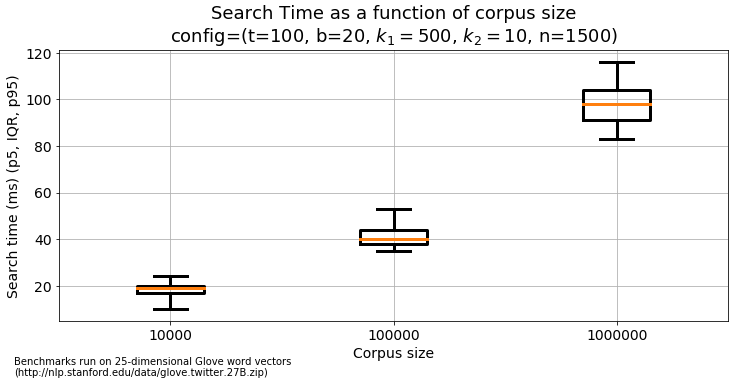

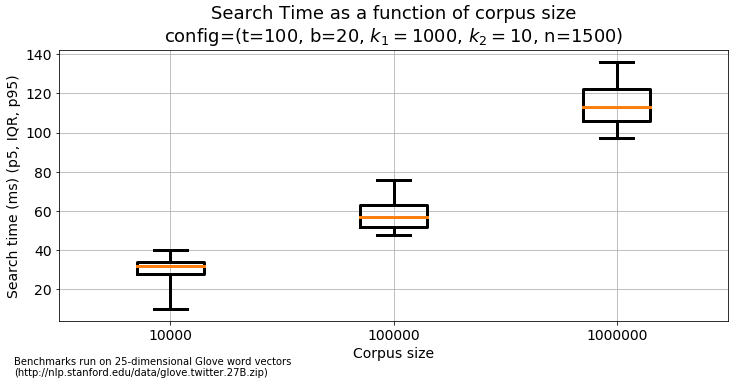

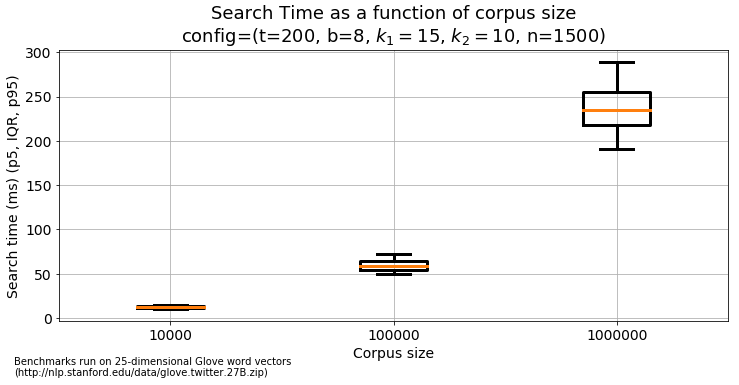

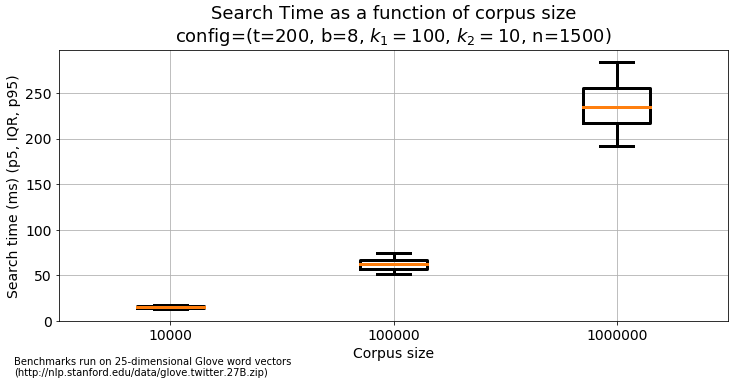

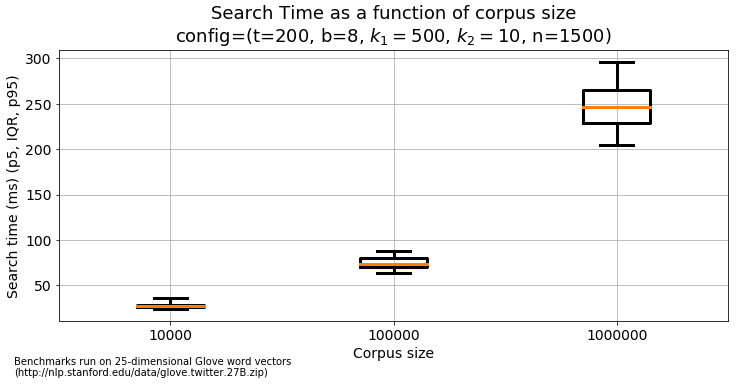

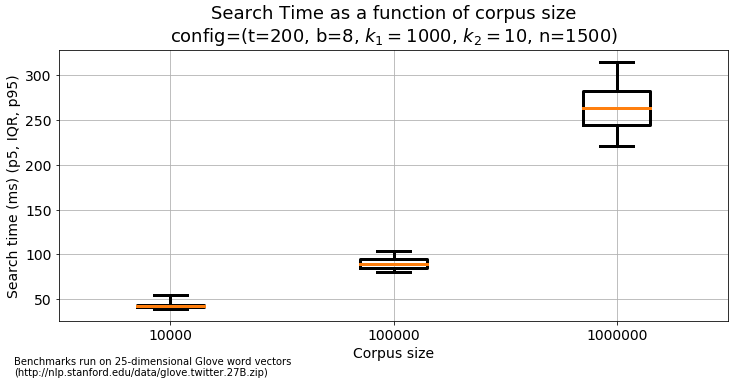

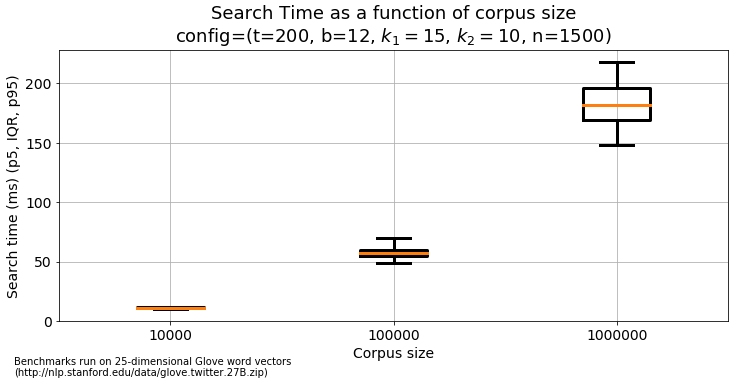

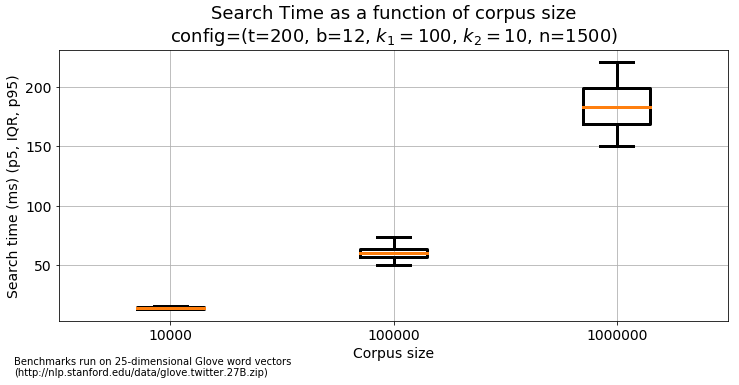

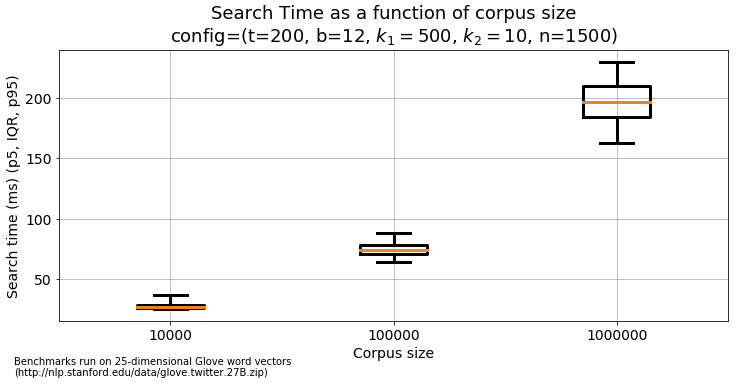

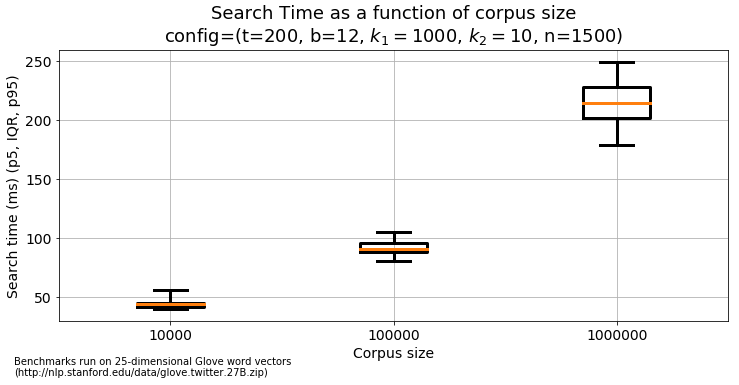

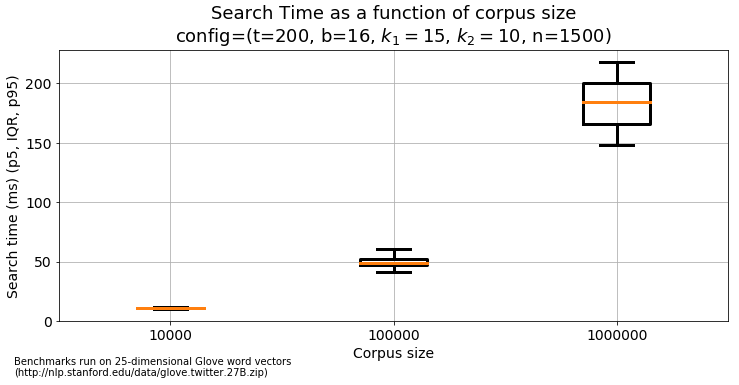

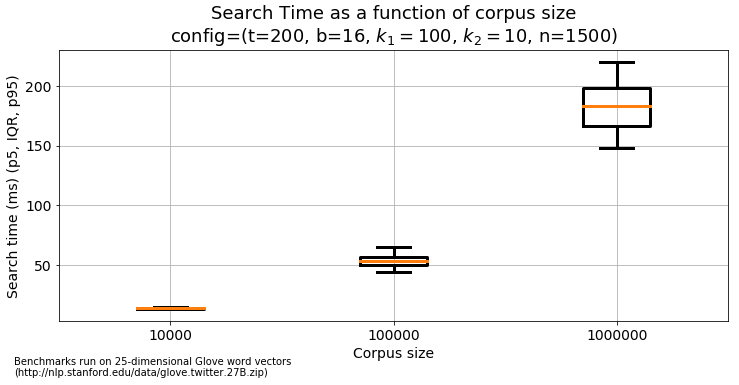

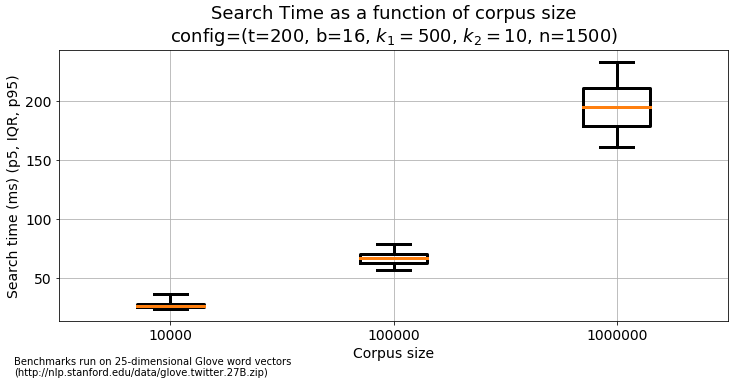

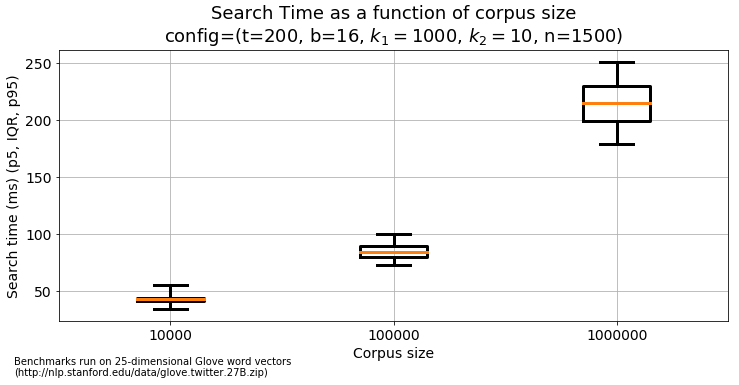

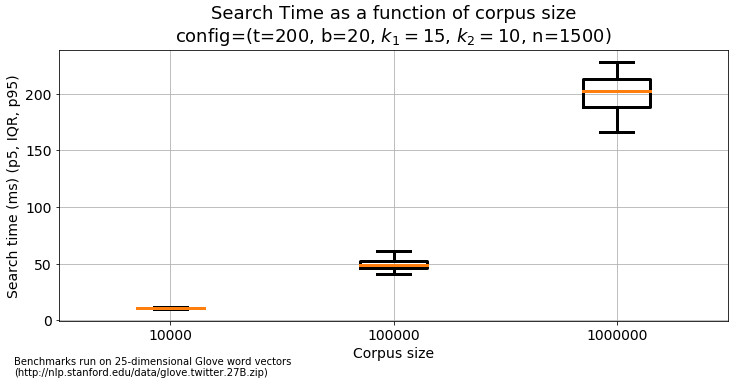

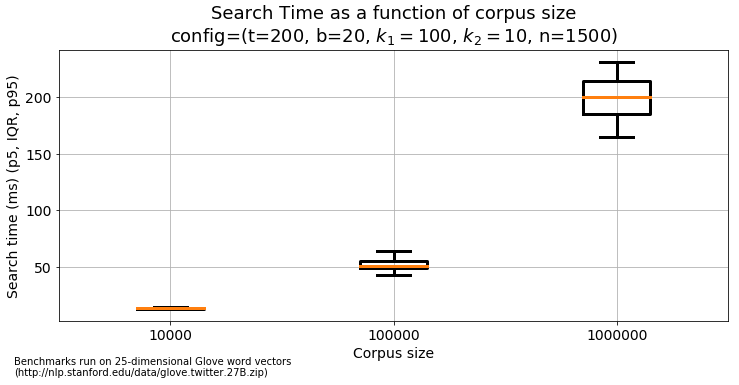

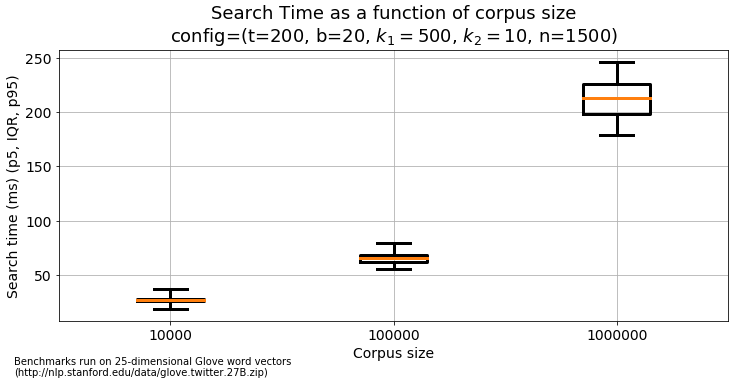

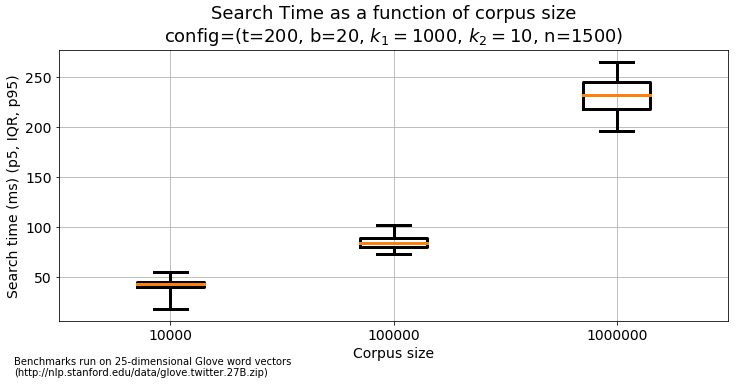

In [14]:
# Plot the search times as a function of corpus size.
df = pd.DataFrame(list(iter_metrics()))

for key, df_ in df.groupby(["nb_tables", "nb_bits", "k1", "k2"]):
    df_ = df_.sort_values("nb_docs", ascending=True)
    
    # Boxplot...
    bpdata = df_.search_times.values
    plt.figure(figsize=(12, 5))
    plt.boxplot(bpdata, showfliers=False, 
                whis=[5, 95],
                boxprops={"linewidth": 3},
                medianprops={"linewidth": 3},
                whiskerprops={"linewidth": 3},
                capprops={"linewidth": 3})
    plt.xticks(range(1, len(bpdata) + 1), df_.nb_docs.values, size=14)
    plt.yticks(size=14)
    plt.title("Search Time as a function of corpus size\nconfig=(t=%d, b=%d, $k_1=%d$, $k_2=%d$, n=%d)" % (
        *key, len(bpdata[0])), size=18)
    plt.xlabel("Corpus size", size=14)
    plt.ylabel("Search time (ms) (p5, IQR, p95)", size=14)
    plt.grid(True)
    
    y0, y1 = plt.gca().get_ylim()
    h = y1 - y0
    plt.text(0.3, y0 - (h * 0.2), BENCHMARK_DESCRIPTION)
    plt.show()

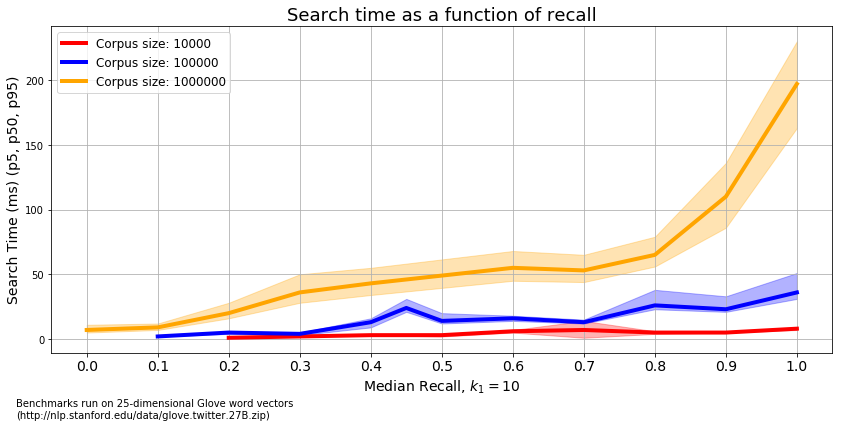

|    |   Corpus size |   Med. recall |   Med. search time |   k1 |   nb_tables |   nb_bits |
|----|---------------|---------------|--------------------|------|-------------|-----------|
|  0 |       1000000 |          1    |                197 |  500 |         200 |        12 |
|  1 |       1000000 |          0.9  |                110 |  500 |         100 |        12 |
|  2 |       1000000 |          0.8  |                 65 | 1000 |          50 |        12 |
|  3 |       1000000 |          0.7  |                 53 |  500 |          50 |        12 |
|  4 |       1000000 |          0.6  |                 55 |  500 |          50 |        20 |
|  5 |       1000000 |          0.4  |                 43 |  100 |          50 |        12 |
|  6 |       1000000 |          0.3  |                 36 | 1000 |          10 |         8 |
|  7 |       1000000 |          0.2  |                 20 |  500 |          10 |        12 |
|  8 |       1000000 |          0.1  |                  9 |  100 |    

In [57]:
# Plot speed/recall frontier.
# This is the point with the lowest median search time for every unique median IOU, grouped by corpus size.

plt.figure(figsize=(14, 6))
rows = []
for row in iter_metrics():
    row["reca50"] = np.median(row["search_recalls"])
    row["time50"] = np.median(row["search_times"])
    rows.append(row)

df = pd.DataFrame(rows)
best_configs = []
colors = iter(["red", "blue", "orange", "purple", "cyan"])

for nb_docs, df_ in df.groupby(["nb_docs"]):
    X, Y0, YM, Y1 = [], [], [], []
    for reca50, df_ in df_.groupby(["reca50"]):
        df_ = df_.sort_values("time50", ascending=True)
        _, r = next(df_.iterrows())
        X.append(reca50)
        YM.append(r.time50)
        Y0.append(np.percentile(r.search_times, 5))
        Y1.append(np.percentile(r.search_times, 95))
        best_configs.append((
            nb_docs, reca50, r.time50, r.k1, r.nb_tables, r.nb_bits))
    c = next(colors)
    plt.fill_between(X, Y0, Y1, alpha=0.3, color=c)
    plt.plot(X, YM, label="Corpus size: %d" % nb_docs, linewidth=4, color=c)
plt.legend(loc='upper left', prop={'size': 12})
plt.title("Search time as a function of recall", size=18)
plt.ylabel("Search Time (ms) (p5, p50, p95)", size=14)
plt.xlabel("Median Recall, $k_1=10$", size=14)
plt.xticks(np.arange(0, 11) / 10, np.arange(0, 11) / 10, size=14)
y0, y1 = plt.gca().get_ylim()
h = y1 - y0
plt.text(-0.1, y0 - (h * 0.2), BENCHMARK_DESCRIPTION)
plt.grid(True)
plt.show()

columns = ["Corpus size", "Med. recall", "Med. search time", "k1", "nb_tables", "nb_bits"]
df = pd.DataFrame(best_configs, columns=columns)
df.sort_values(["Corpus size", "Med. recall"], ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

df["Corpus size"] = df["Corpus size"].astype(str)
print(tabulate(df, columns, "pipe").replace("-:", "--"))